### Carga de los datos

In [45]:
import numpy as np
import pandas as pd

# Establecer la semilla aleatoria para NumPy, TensorFlow, el generador de números aleatorios de Python
# y para la función de hash interna de Python
import tensorflow as tf
import random
import os
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)
os.environ['PYTHONHASHSEED'] = str(42)
# Reducir el uso de múltiples núcleos para evitar variabilidad
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ['OMP_NUM_THREADS'] = '1'
os.environ['TF_NUM_INTRAOP_THREADS'] = '1'
os.environ['TF_NUM_INTEROP_THREADS'] = '1'

data_train=pd.read_excel('Datos_train.xlsx',index_col=0)
data_test = pd.read_excel('Datos_test.xlsx',index_col=0)  
etiq_verd_train=data_train[['Etiq']]
etiq_verd_test=data_test[['Etiq']]
data_train = data_train[['Temperatura','Consumo_Lavanderia', 'Consumo_Cocina', 
                         'Resto_Consumo', 'Habitantes']]
data_test = data_test[['Temperatura','Consumo_Lavanderia', 'Consumo_Cocina', 
                         'Resto_Consumo', 'Habitantes']]

print(data_train.head())
print(data_test.head())

data_train=np.array(data_train)
data_test=np.array(data_test)

     Temperatura  Consumo_Lavanderia  Consumo_Cocina  Resto_Consumo  \
518     0.395349            0.246374        0.331337       0.111447   
601     0.395349            0.198473        0.273396       0.490744   
602     0.139535            0.167176        0.252471       0.490744   
968     0.418605            0.317557        0.151627       0.576502   
325     0.651163            0.231298        0.182481       0.492255   

     Habitantes  
518      0.5625  
601      0.2500  
602      0.2500  
968      0.5625  
325      0.3750  
      Temperatura  Consumo_Lavanderia  Consumo_Cocina  Resto_Consumo  \
847      0.604651            0.203817        0.187748       0.219500   
298      0.232558            0.360687        0.181398       0.105780   
197      0.418605            0.243321        0.338336       0.170759   
1065     0.441860            0.244656        0.129014       0.223649   
881      0.697674            0.298664        0.159391       0.408765   

      Habitantes  
847       0.4

### Entrenamiento del modelo

In [75]:
from keras.models import Model
from keras.layers import Input, Dense
from keras.optimizers import Adam
from tensorflow.keras.initializers import GlorotUniform

tf.random.set_seed(42)

# Crear el modelo autoencoder con inicialización reproducible
input_dim = data_train.shape[1]
encoding_dim = 8  # Dimensión de la capa oculta 
input_layer = Input(shape=(input_dim,))
encoder_layer = Dense(encoding_dim, activation='relu', kernel_initializer=GlorotUniform(seed=42))(input_layer)
decoder_layer = Dense(input_dim, activation='sigmoid', kernel_initializer=GlorotUniform(seed=42))(encoder_layer)

autoencoder = Model(inputs=input_layer, outputs=decoder_layer)
autoencoder.compile(optimizer=Adam(learning_rate=0.01), loss='mean_squared_error')

# Entrenar el autoencoder
history = autoencoder.fit(data_train, data_train, epochs=100, batch_size=32, 
                          shuffle=False, validation_split=0.1, verbose=0)

<IPython.core.display.Javascript object>


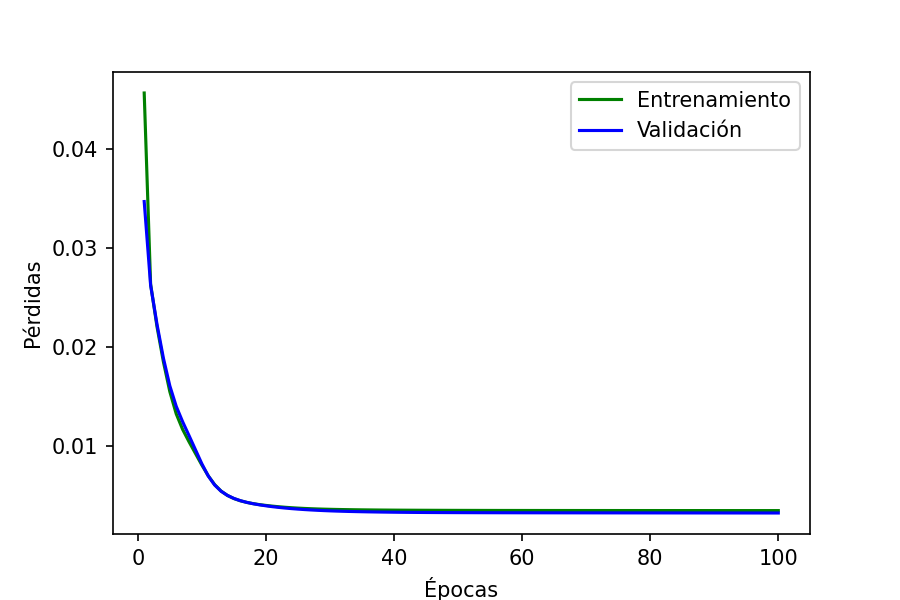

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


<IPython.core.display.Javascript object>


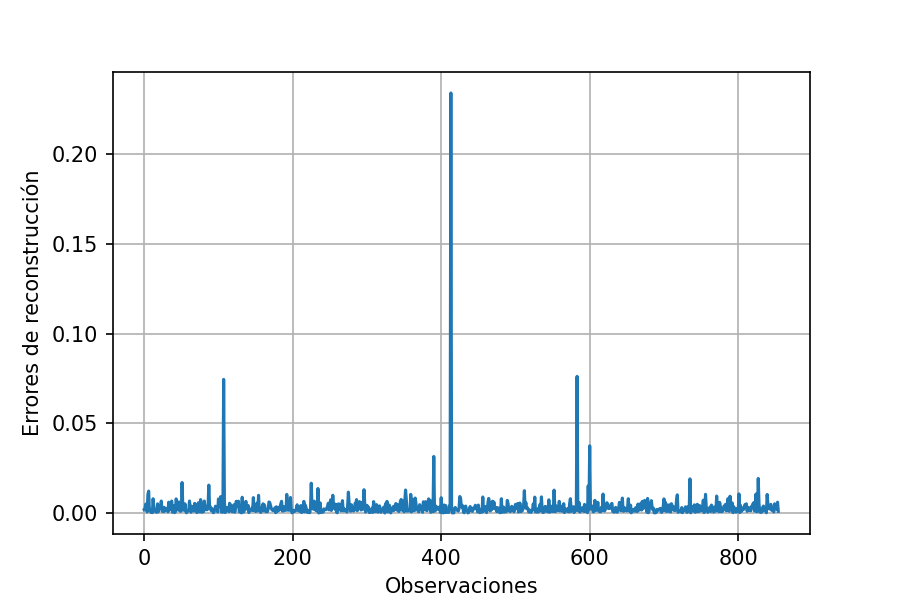

In [76]:
import matplotlib.pyplot as plt

train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Crear la gráfica
plt.figure(figsize=(6, 4))
epochs = range(1, len(train_loss) + 1)
plt.plot(epochs, train_loss, 'g', label='Entrenamiento')
plt.plot(epochs, val_loss, 'b', label='Validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdidas')
plt.legend()
plt.show()

# Cálculo de los errores de reconstrucción
train_preds = autoencoder.predict(data_train)

# Evaluar el autoencoder en el conjunto de train
mse_train_errors = np.mean(np.power(data_train - train_preds, 2), axis=1)

plt.figure(figsize=(6, 4))
plt.grid(True)
plt.plot(mse_train_errors)
plt.xlabel('Observaciones')
plt.ylabel('Errores de reconstrucción')
plt.show()

### Análisis de TDA, TFA, Precisión y Umbral

<IPython.core.display.Javascript object>


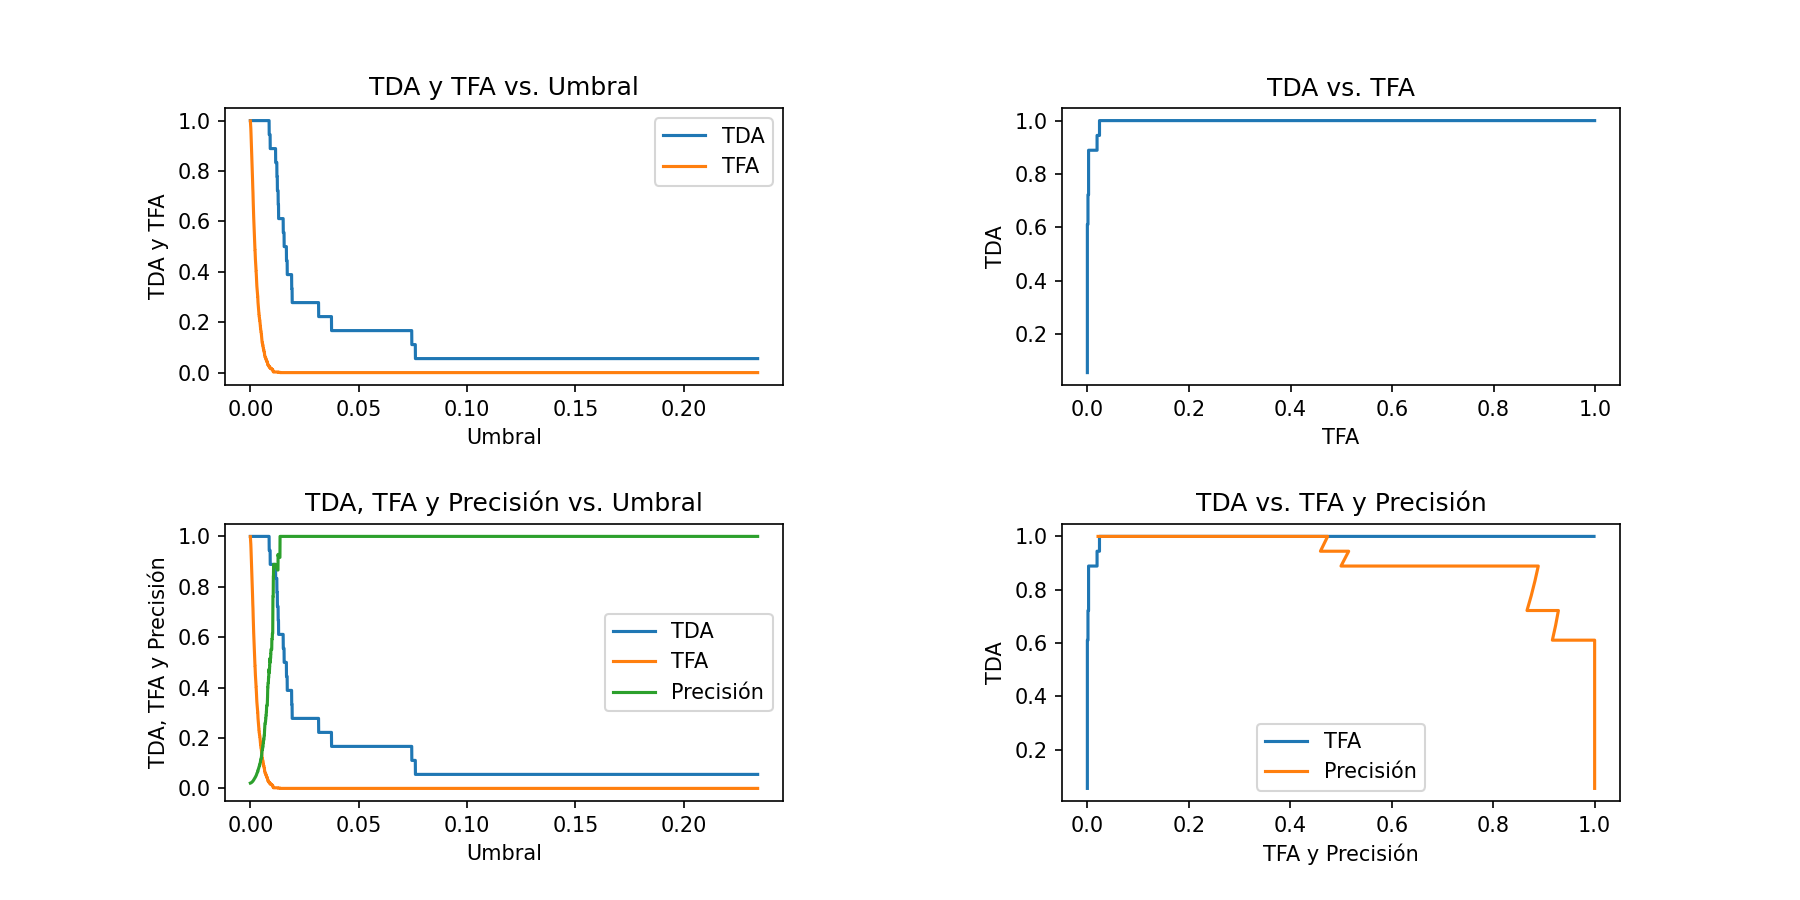

In [77]:
from sklearn.metrics import confusion_matrix

umbral = np.arange(np.min(mse_train_errors), np.max(mse_train_errors), 0.00001)
tda=[]
tfa=[]
precis=[]

for i in range(len(umbral)):
    predicciones = np.where(mse_train_errors > umbral[i], 1, 0)
    cm = confusion_matrix(etiq_verd_train, predicciones) 
    VP = cm[1, 1]
    FP = cm[0, 1]
    VN = cm[0, 0]
    FN = cm[1, 0]
    TDA= VP/(VP+FN) # Describe a la clase positiva (Clase Pos=VP+FN;Clase Neg=VN+FP)
    TFA=FP/(VN+FP)
    PREC=VP/(VP+FP) # Describe a las predicciones positivas correctas (PrediccPosit=VP+FP)
    tda.append(TDA)
    tfa.append(TFA)
    precis.append(PREC)

fig, axes = plt.subplots(2, 2, figsize=(12, 6))
ax1, ax2, ax3, ax4 = axes.flatten()

ax1.plot(umbral, tda, label='TDA')
ax1.plot(umbral, tfa, label='TFA')
ax1.set_xlabel('Umbral')  
ax1.set_ylabel('TDA y TFA') 
ax1.set_title('TDA y TFA vs. Umbral')
ax1.legend()

ax2.plot(tfa, tda)
ax2.set_xlabel('TFA')  
ax2.set_ylabel('TDA')  
ax2.set_title('TDA vs. TFA')

ax3.plot(umbral, tda, label='TDA')
ax3.plot(umbral, tfa, label='TFA')
ax3.plot(umbral,precis,label='Precisión')
ax3.set_xlabel('Umbral')  
ax3.set_ylabel('TDA, TFA y Precisión') 
ax3.set_title('TDA, TFA y Precisión vs. Umbral')
ax3.legend()

ax4.plot(tfa,tda,label='TFA')
ax4.plot(precis, tda, label='Precisión')
ax4.set_xlabel('TFA y Precisión') 
ax4.set_ylabel('TDA') 
ax4.set_title('TDA vs. TFA y Precisión')
ax4.legend()

plt.subplots_adjust(hspace=0.5, wspace=0.5)
plt.show()

### Selección manual de valores de TDA y TFA

<IPython.core.display.Javascript object>


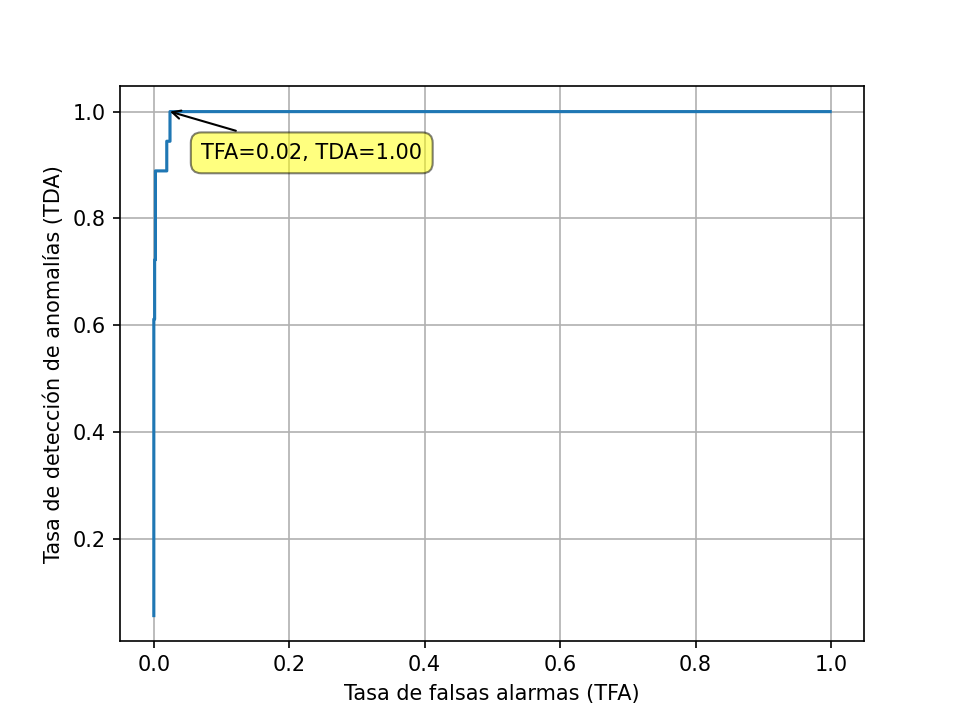

In [78]:
%matplotlib notebook
import mplcursors

fig, ax = plt.subplots()
ax.plot(tfa, tda)  
plt.xlabel('Tasa de falsas alarmas (TFA)')
plt.ylabel('Tasa de detección de anomalías (TDA)')
plt.grid(True)
# Habilitar la selección de puntos
cursor = mplcursors.cursor(ax, hover=True)
cursor.connect("add", lambda sel: sel.annotation.set_text(f'TFA={sel.target[0]:.2f}, TDA={sel.target[1]:.2f}'))
cursor.connect("add", lambda sel: sel.annotation.draggable(True))

plt.show()

### Cálculo del umbral, y resultados del entrenamiento (data_train)

In [79]:
from sklearn.metrics import classification_report

valor_tfa = input("Valor de TFA: ")
valor_tda = input("Valor de TDA: ")
valor_tfa=float(valor_tfa)
valor_tda=float(valor_tda)

def encontrar_indice_mas_cercano(tfa, tda, valor_tfa, valor_tda):
    distancias = []
    for i in range(len(tfa)):
        distancia = np.sqrt((tfa[i] - valor_tfa)**2 + (tda[i] - valor_tda)**2)
        distancias.append(distancia)
    indice_minimo = np.argmin(distancias)
    return indice_minimo

index_umb=encontrar_indice_mas_cercano(tfa, tda, valor_tfa, valor_tda)
umbral_dec=umbral[index_umb]
print ("Umbral para la decisión:", umbral_dec)
print("-----------------------------------------------------------------------")

anomalias = data_train[mse_train_errors > umbral_dec]
print("Número de anomalías detectadas:", len(anomalias))
print("------------------------------------------------------------------------")

etiq_pred = np.where(mse_train_errors > umbral_dec, 1, 0)
print(classification_report(etiq_verd_train, etiq_pred))
print("------------------------------------------------------------------------")

cm = confusion_matrix(etiq_verd_train, etiq_pred)
print(cm)
VP = cm[1, 1]
FP = cm[0, 1]
VN = cm[0, 0]
FN = cm[1, 0]
print("VP:",VP)
print("FP:",FP)
print("VN:",VN)
print("FN:",FN)
print("------------------------------------------------------------------------")

TDA= VP/(VP+FN)
TFA=FP/(VN+FP)
Precision=VP/(VP+FP)
F1 = 2 * (Precision * TDA) / (Precision + TDA)

print("TDA:", TDA)
print("TFA:", TFA)
print("Precision:", Precision)
print("F1:", F1)


Valor de TFA: 0.02
Valor de TDA: 1
Umbral para la decisión: 0.008570738939886594
-----------------------------------------------------------------------
Número de anomalías detectadas: 38
------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       837
           1       0.47      1.00      0.64        18

    accuracy                           0.98       855
   macro avg       0.74      0.99      0.82       855
weighted avg       0.99      0.98      0.98       855

------------------------------------------------------------------------
[[817  20]
 [  0  18]]
VP: 18
FP: 20
VN: 817
FN: 0
------------------------------------------------------------------------
TDA: 1.0
TFA: 0.023894862604540025
Precision: 0.47368421052631576
F1: 0.6428571428571429


### Análisis y resultados en la validación (data_test)

In [57]:
# Calcula los errores de reconstrucción
test_preds = autoencoder.predict(data_test)

# Evaluar el autoencoder en el conjunto de prueba
mse_test_errors = np.mean(np.power(data_test - test_preds, 2), axis=1)

anomalias = data_test[mse_test_errors > umbral_dec]
print("Número de anomalías detectadas:", len(anomalias))
print("------------------------------------------------------------------------")

etiq_pred = np.where(mse_test_errors > umbral_dec, 1, 0)
print(classification_report(etiq_verd_test, etiq_pred))
print("------------------------------------------------------------------------")

cm = confusion_matrix(etiq_verd_test, etiq_pred)
print(cm)
VP = cm[1, 1]
FP = cm[0, 1]
VN = cm[0, 0]
FN = cm[1, 0]
print("VP:",VP)
print("FP:",FP)
print("VN:",VN)
print("FN:",FN)
print("------------------------------------------------------------------------")

TDA= VP/(VP+FN)
TFA=FP/(VN+FP)
Precision=VP/(VP+FP)
F1 = 2 * (Precision * TDA) / (Precision + TDA)

print("TDA:", TDA)
print("TFA:", TFA)
print("Precision:", Precision)
print("F1:", F1)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Número de anomalías detectadas: 17
------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.97      0.98       204
           1       0.59      1.00      0.74        10

    accuracy                           0.97       214
   macro avg       0.79      0.98      0.86       214
weighted avg       0.98      0.97      0.97       214

------------------------------------------------------------------------
[[197   7]
 [  0  10]]
VP: 10
FP: 7
VN: 197
FN: 0
------------------------------------------------------------------------
TDA: 1.0
TFA: 0.03431372549019608
Precision: 0.5882352941176471
F1: 0.7407407407407407


#### Mostrar cada gráfico por separado

<IPython.core.display.Javascript object>


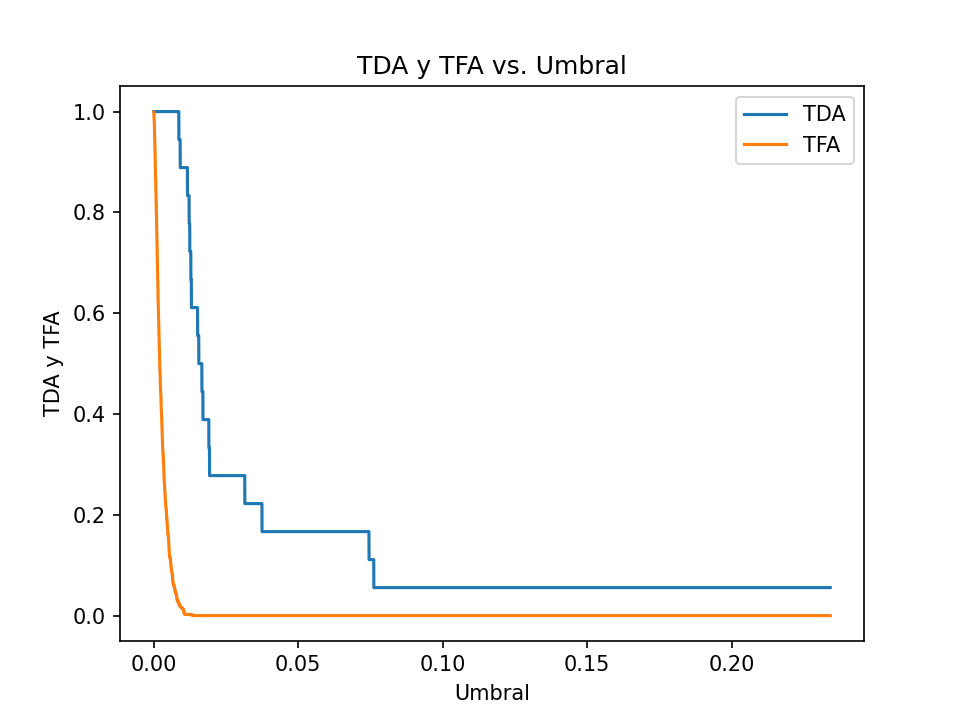

<IPython.core.display.Javascript object>


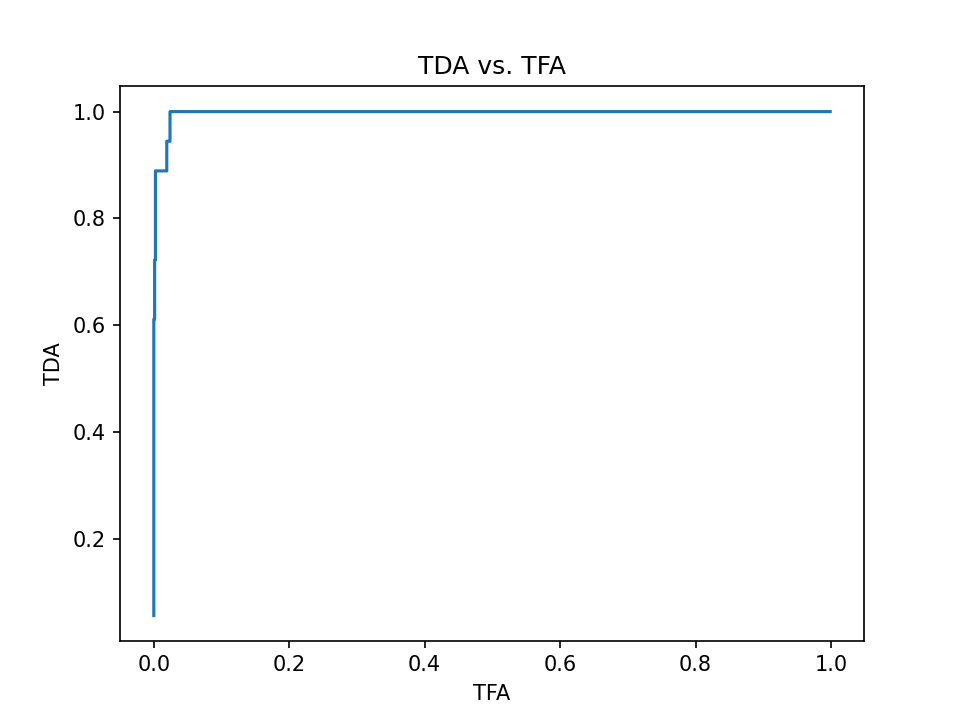

<IPython.core.display.Javascript object>


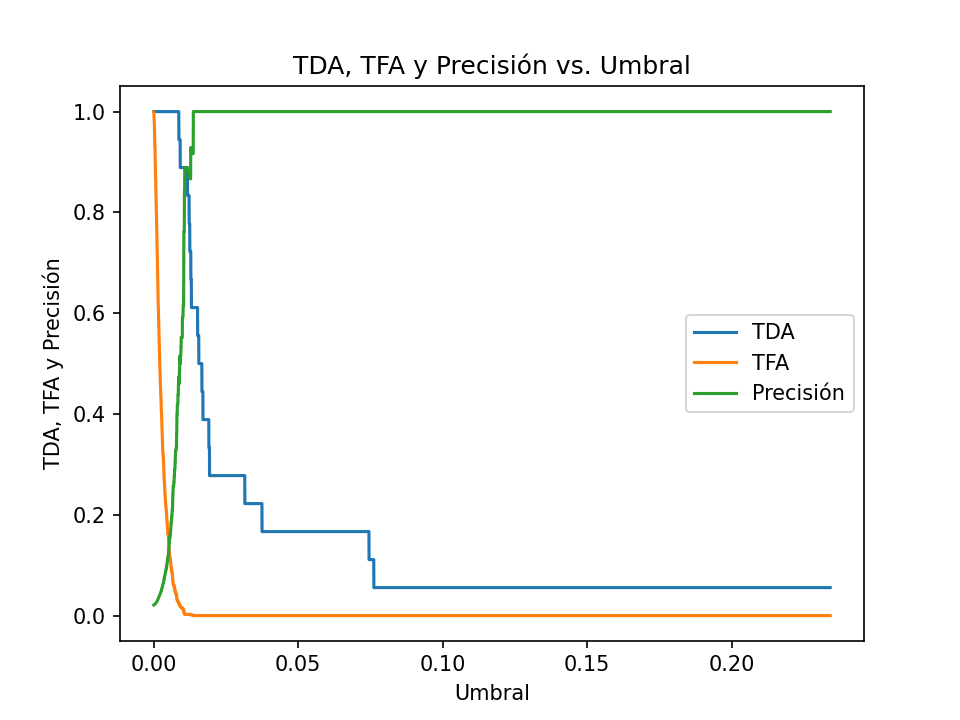

<IPython.core.display.Javascript object>


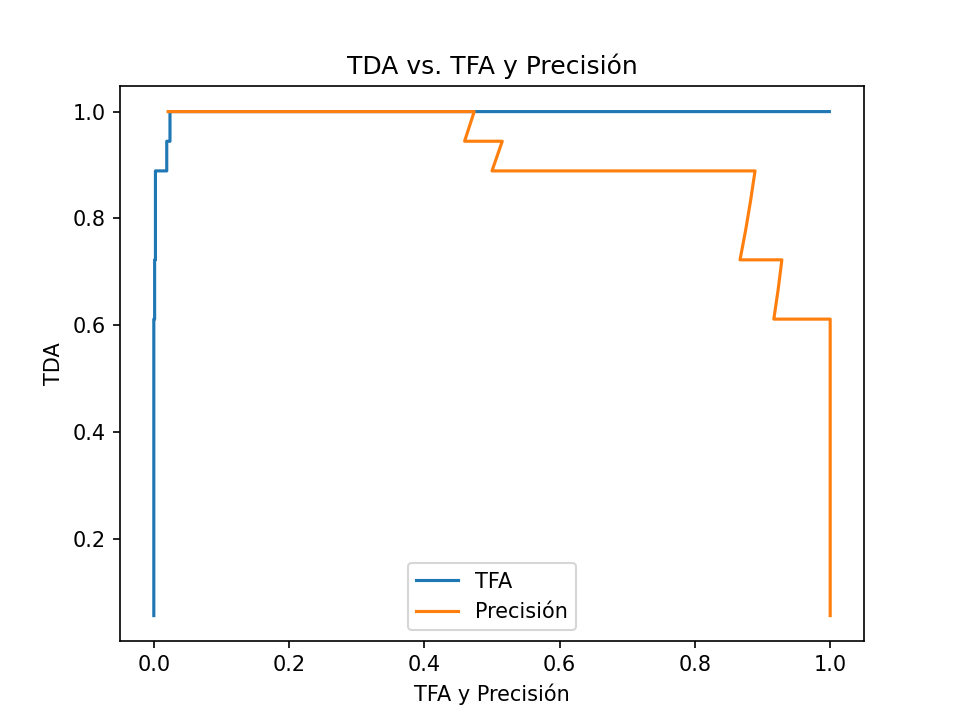

In [58]:
import matplotlib.pyplot as plt

# Supongamos que 'axes' es tu array de subplots originales
figures = []

# Graficar los tres gráficos originales por separado
for i, ax in enumerate(axes.flatten(), start=1):
    fig, new_ax = plt.subplots()
    for line in ax.get_lines():
        new_ax.plot(line.get_xdata(), line.get_ydata(), label=line.get_label())
    new_ax.set_title(ax.get_title())
    new_ax.set_xlabel(ax.get_xlabel())
    new_ax.set_ylabel(ax.get_ylabel())
    if i == 1 or i == 3 or i == 4:
        new_ax.legend()
    figures.append(fig)
    plt.show()

#### Graficar una línea horizontal para ajuste fino del umbral

<IPython.core.display.Javascript object>


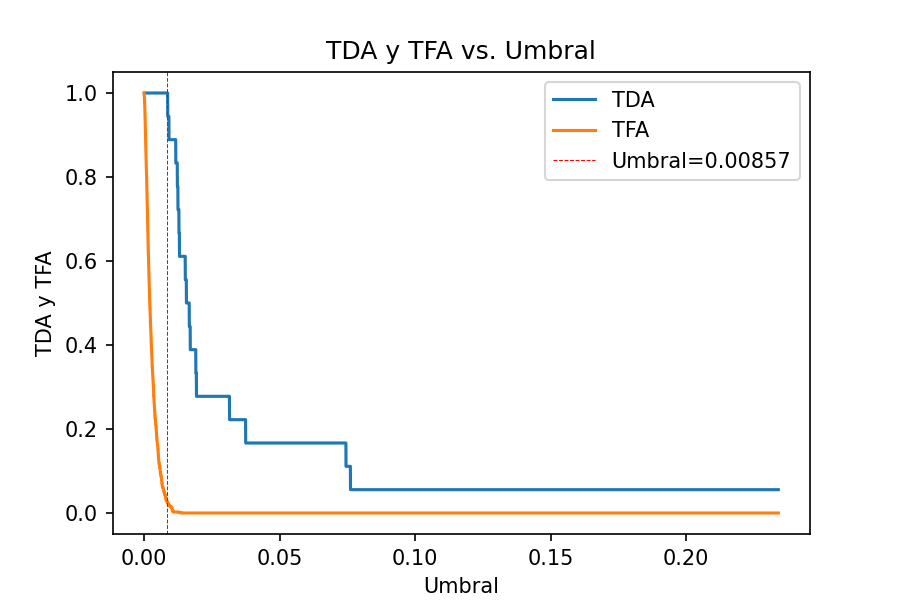

<IPython.core.display.Javascript object>


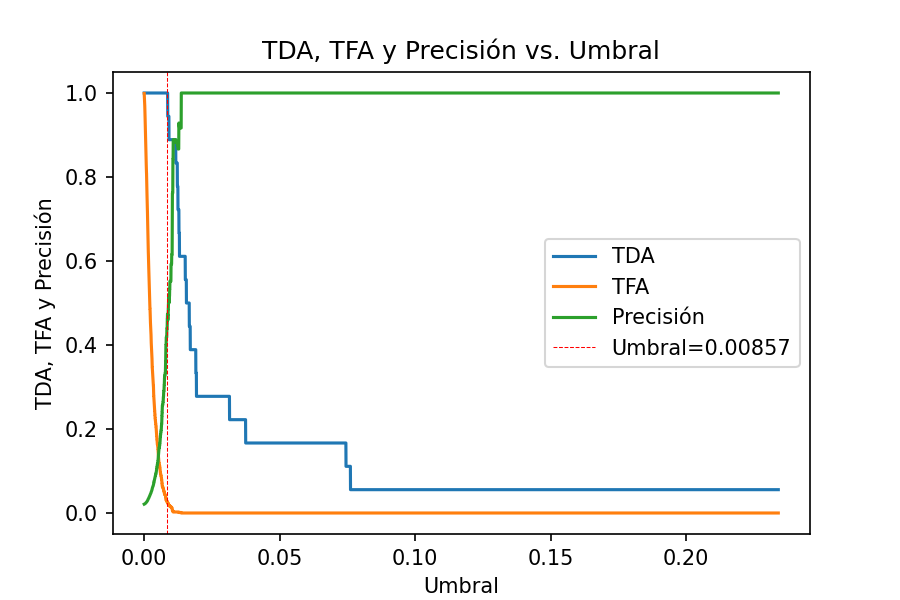

In [59]:
# Crear el gráfico
plt.figure(figsize=(6, 4))
plt.plot(umbral, tda, label='TDA')
plt.plot(umbral, tfa, label='TFA')
plt.xlabel('Umbral')
plt.ylabel('TDA y TFA')
plt.title('TDA y TFA vs. Umbral')
plt.legend()
# Agregar líneas verticales discontinuas
plt.axvline(x=umbral_dec, color='r', linestyle='--', linewidth=0.5, label=f'Umbral={umbral_dec:.5f}')
plt.legend()
plt.show()

# Crear el gráfico
plt.figure(figsize=(6, 4))
plt.plot(umbral, tda, label='TDA')
plt.plot(umbral, tfa, label='TFA')
plt.plot(umbral,precis,label='Precisión')
plt.xlabel('Umbral')  
plt.ylabel('TDA, TFA y Precisión') 
plt.title('TDA, TFA y Precisión vs. Umbral')
plt.legend()
# Agregar líneas verticales discontinuas
plt.axvline(x=umbral_dec, color='r', linestyle='--', linewidth=0.5, label=f'Umbral={umbral_dec:.5f}')
plt.legend()
plt.show()

### Ajuste fino del umbral

In [60]:
umbral_fino = input("Valor del umbral:")
umbral_fino=float(umbral_fino)

print(" \n  \n ---------------- Datos de entrenamiento ----------------------------- \n ")
anomalias = data_train[mse_train_errors > umbral_fino]
print("Número de anomalías detectadas:", len(anomalias))


etiq_pred = np.where(mse_train_errors > umbral_fino, 1, 0)
print("------------------------------------------------------------------------")

cm = confusion_matrix(etiq_verd_train, etiq_pred)
print(cm)
VP = cm[1, 1]
FP = cm[0, 1]
VN = cm[0, 0]
FN = cm[1, 0]
print("VP:",VP)
print("FP:",FP)
print("VN:",VN)
print("FN:",FN)
print("------------------------------------------------------------------------")

TDA= VP/(VP+FN)
TFA=FP/(VN+FP)
Precision=VP/(VP+FP)
F1 = 2 * (Precision * TDA) / (Precision + TDA)

print("TDA:", TDA)
print("TFA:", TFA)
print("Precision:", Precision)
print("F1:", F1)

print(" \n  \n ---------------- Datos de validación --------------------------- \n ")
anomalias = data_test[mse_test_errors > umbral_fino]
print("Número de anomalías detectadas:", len(anomalias))


etiq_pred = np.where(mse_test_errors > umbral_fino, 1, 0)
print("------------------------------------------------------------------------")

cm = confusion_matrix(etiq_verd_test, etiq_pred)
print(cm)
VP = cm[1, 1]
FP = cm[0, 1]
VN = cm[0, 0]
FN = cm[1, 0]
print("VP:",VP)
print("FP:",FP)
print("VN:",VN)
print("FN:",FN)
print("------------------------------------------------------------------------")

TDA= VP/(VP+FN)
TFA=FP/(VN+FP)
Precision=VP/(VP+FP)
F1 = 2 * (Precision * TDA) / (Precision + TDA)

print("TDA:", TDA)
print("TFA:", TFA)
print("Precision:", Precision)
print("F1:", F1)


Valor del umbral:0.00865
 
  
 ---------------- Datos de entrenamiento ----------------------------- 
 
Número de anomalías detectadas: 38
------------------------------------------------------------------------
[[817  20]
 [  0  18]]
VP: 18
FP: 20
VN: 817
FN: 0
------------------------------------------------------------------------
TDA: 1.0
TFA: 0.023894862604540025
Precision: 0.47368421052631576
F1: 0.6428571428571429
 
  
 ---------------- Datos de validación --------------------------- 
 
Número de anomalías detectadas: 16
------------------------------------------------------------------------
[[198   6]
 [  0  10]]
VP: 10
FP: 6
VN: 198
FN: 0
------------------------------------------------------------------------
TDA: 1.0
TFA: 0.029411764705882353
Precision: 0.625
F1: 0.7692307692307693


# Ajuste de hiperparámetros de la red autoencoder
#### Se fueron variando los valores de LR y de neuronas de la capa oculta. LR=0.001 en el método de Adam. Al añadir regularización (Dropout), no se obtienen buenos resultados

<IPython.core.display.Javascript object>


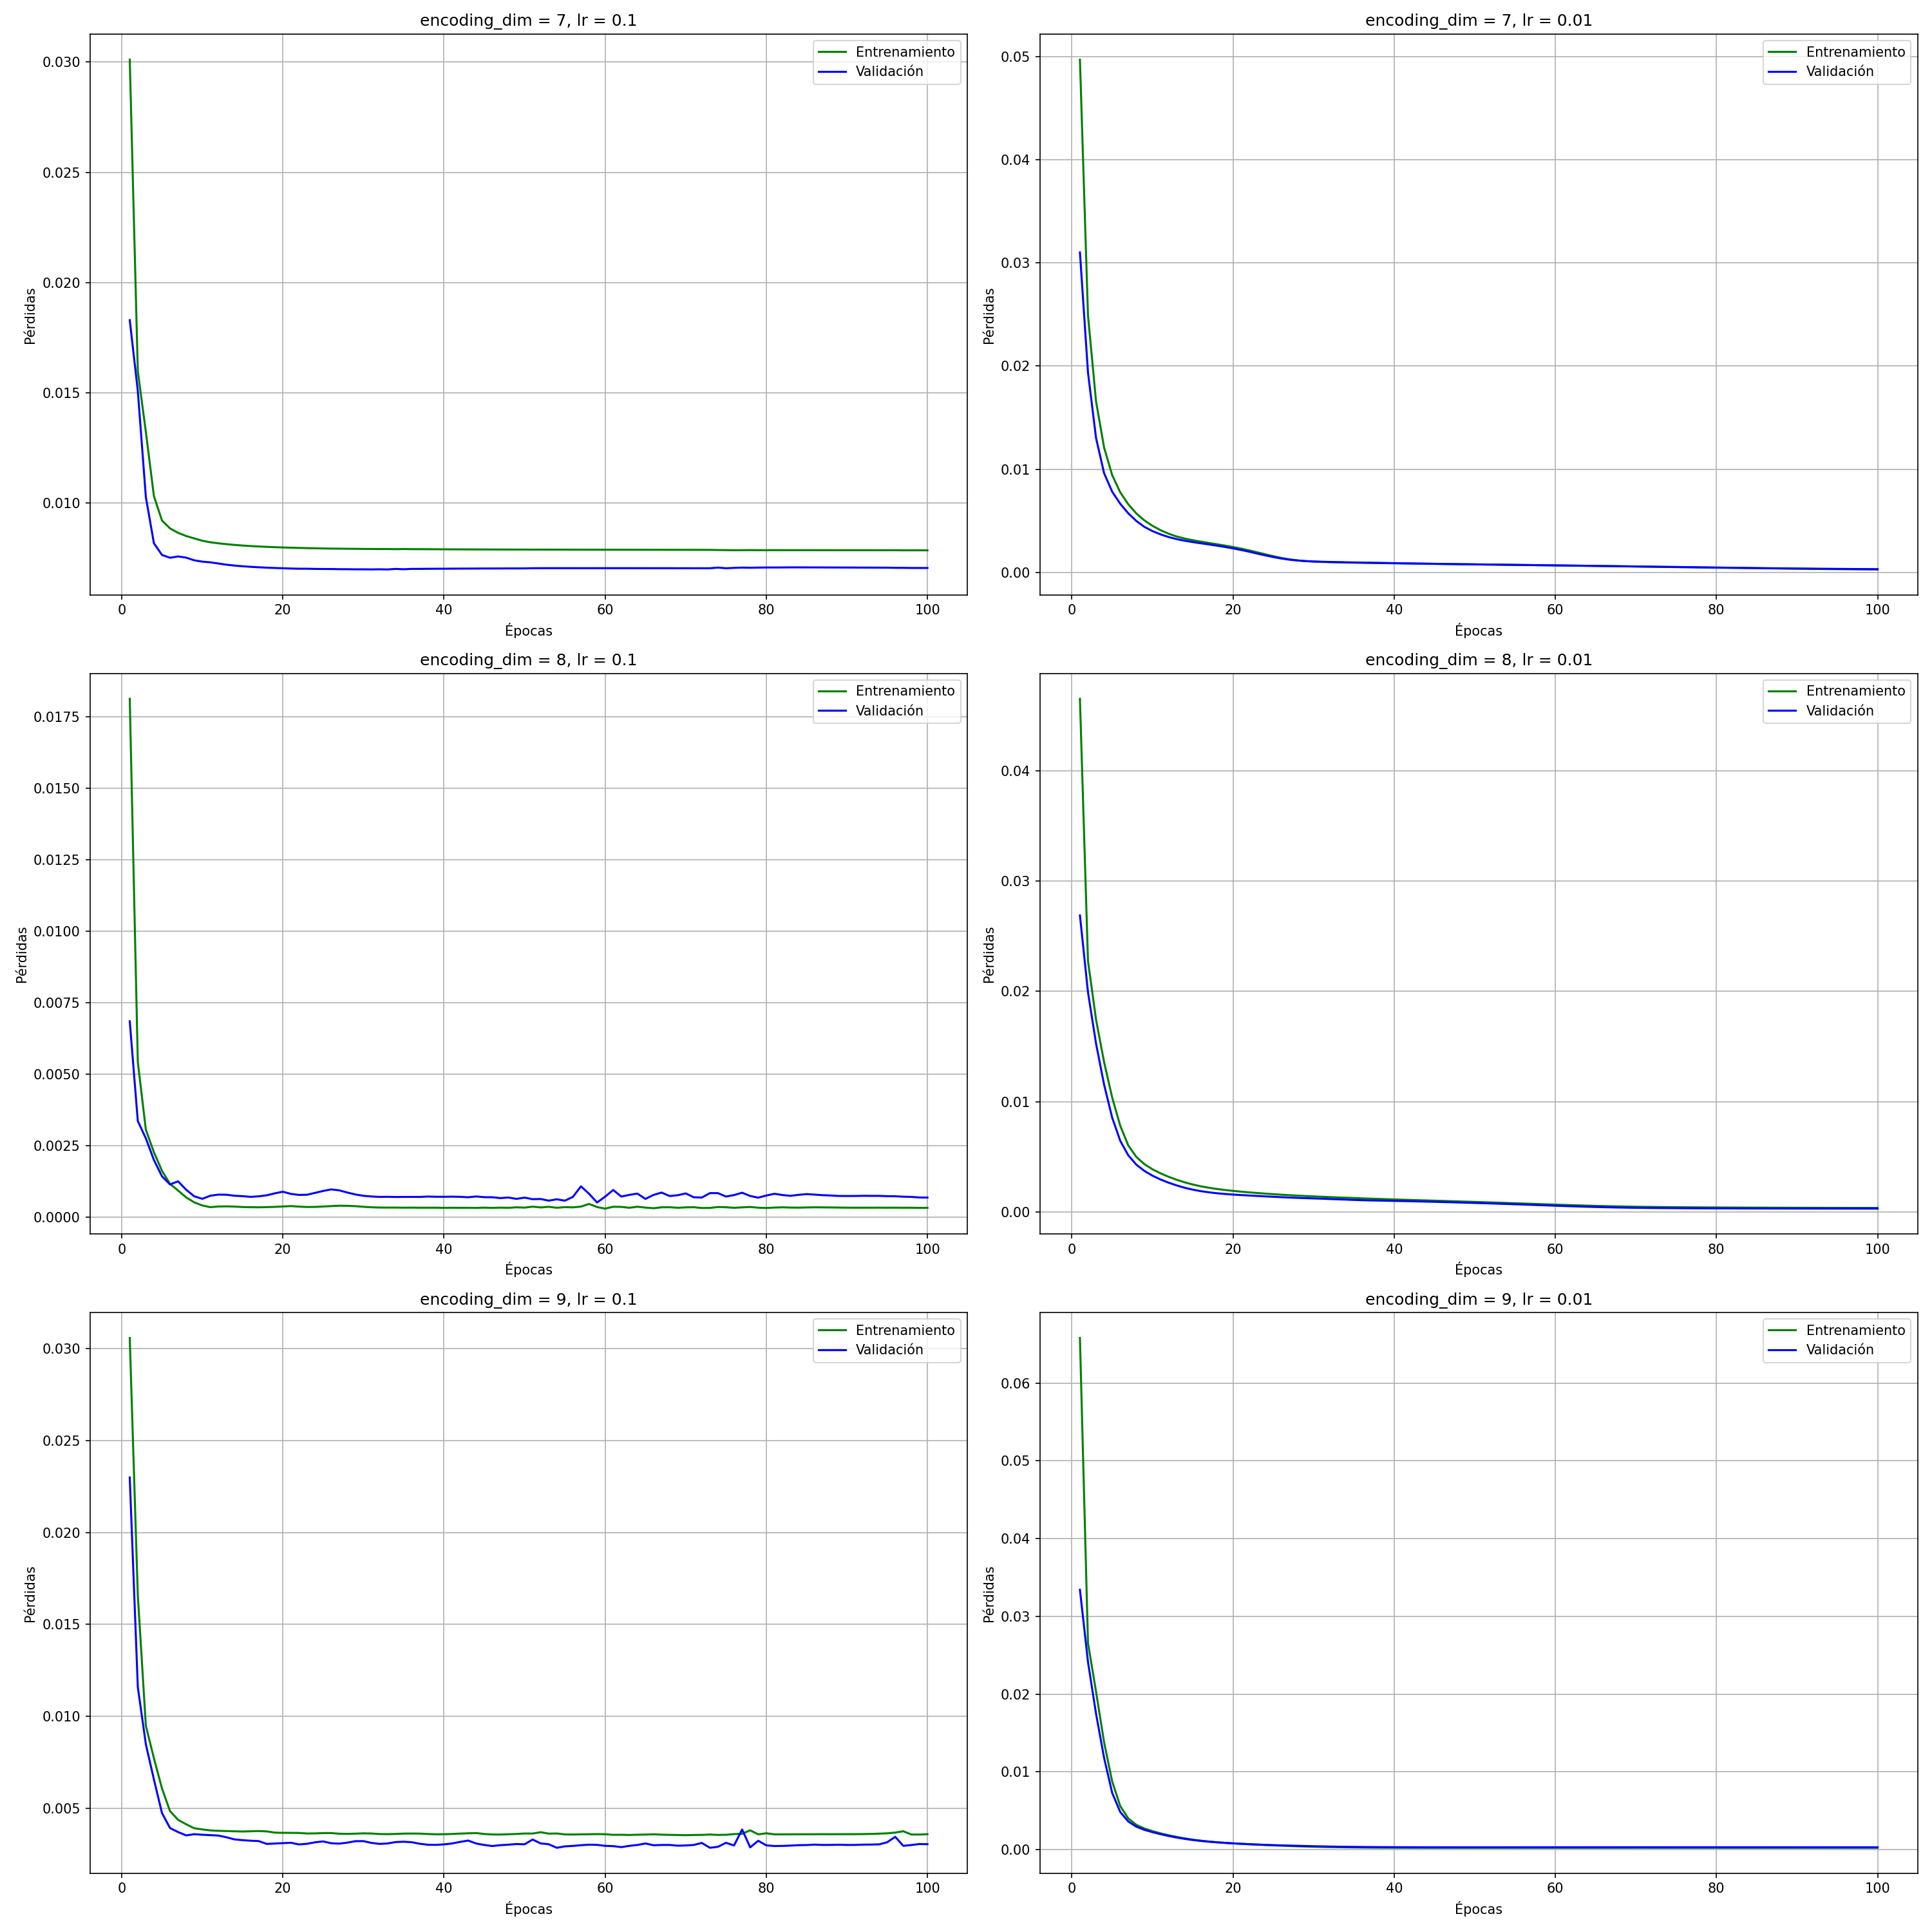

In [67]:
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import Input, Dense, Dropout
from keras.optimizers import Adam

import tensorflow as tf
import random
import os
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)
os.environ['PYTHONHASHSEED'] = str(42)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ['OMP_NUM_THREADS'] = '1'
os.environ['TF_NUM_INTRAOP_THREADS'] = '1'
os.environ['TF_NUM_INTEROP_THREADS'] = '1'

# Cargar los datos
X_test = pd.read_excel('Datos_test.xlsx', index_col=0)
X_train = pd.read_excel('Datos_train.xlsx', index_col=0)

# Crea el modelo autoencoder
input_dim = X_train.shape[1]

# Valores de encoding_dim, learning_rate y regularización a ensayar
encoding_dims = [7,8,9]
learning_rates = [0.1,0.01]
valor_dropout=0

# Crear subplots
fig, axes = plt.subplots(len(encoding_dims), len(learning_rates), figsize=(20, 20))

for i, encoding_dim in enumerate(encoding_dims):
    for j, lr in enumerate(learning_rates):
        # Definir capas del autoencoder
        input_layer = Input(shape=(input_dim,))
        encoder_layer = Dense(encoding_dim, activation='relu')(input_layer)
        encoder_layer = Dropout(valor_dropout)(encoder_layer)
        decoder_layer = Dense(encoding_dim, activation='sigmoid')(encoder_layer)
        decoder_layer = Dense(input_dim, activation='sigmoid')(encoder_layer)
        
        # Crear y compilar el modelo
        autoencoder = Model(inputs=input_layer, outputs=decoder_layer)
        autoencoder.compile(optimizer=Adam(learning_rate=lr), loss='mean_squared_error')
        
        # Entrenar el autoencoder
        history = autoencoder.fit(X_train, X_train, epochs=100, 
                                  batch_size=32, shuffle=False, validation_split=0.1, verbose=0)
        
        # Obtener pérdidas de entrenamiento y validación
        train_loss = history.history['loss']
        val_loss = history.history['val_loss']
        
        # Crear la gráfica en el subplot correspondiente
        epochs = range(1, len(train_loss) + 1)
        ax = axes[i, j]
        ax.plot(epochs, train_loss, 'g', label='Entrenamiento')
        ax.plot(epochs, val_loss, 'b', label='Validación')
        ax.set_title(f'encoding_dim = {encoding_dim}, lr = {lr}')
        ax.set_xlabel('Épocas')
        ax.set_ylabel('Pérdidas')
        ax.legend()
        ax.grid(True)

# Ajustar el layout
plt.tight_layout()
plt.show()
